### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle



# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [2]:
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
#Calling env.py file as environment
env = CabDriver()

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [5]:
def encoded_state(state):
    return ('-'.join(str(e) for e in state))
def encoded_action(action):
    return ('-'.join(str(e) for e in action))

In [6]:
# Tracking q-values for all possible moves from position 4 at the start of the episode
def track_states_(episodes):
    # Sample state action pairs for tracking
    sample_values = [('4-0-0', '1-2'), ('4-0-0', '2-1'), ('4-0-0', '1-3'), ('4-0-0', '3-1'), ('4-0-0', '1-4'), ('4-0-0', '4-1'), ('4-0-0', '1-5'), ('4-0-0', '5-1'), ('4-0-0', '2-3'), 
                       ('4-0-0', '3-2'), ('4-0-0', '2-4'), ('4-0-0', '4-2'), ('4-0-0', '2-5'), ('4-0-0', '5-2'), ('4-0-0', '3-4'), ('4-0-0', '4-3'), ('4-0-0', '3-5'), ('4-0-0', '5-3'), 
                       ('4-0-0', '4-5'), ('4-0-0', '5-4'), ('4-0-0', '0-0')]    
    for q_value in sample_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []

In [7]:
# Function to save q-value for tracking states-action pair
def tracking_saved(current_state, current_action, current_q_value):
    for state in States_track.keys():
        if state == current_state:
            for action in States_track[state].keys():
                if action == current_action:
                    States_track[state][action].append(current_q_value)

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.98
        self.learning_rate =  0.01      
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_decay = -0.0008
        self.epsilon_min = 0.00001
        
        self.batch_size = 32  
        self.train_start = 50
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

       # create main model and target model
        #print ("Main NN Model : ")
        self.model = self.build_model()
        print ("\nTarget NN Model : ")
        self.target_model = self.build_model()

        
            
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # input layer - input dimension would be state size
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        
        # layer - 2
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # layer - 3
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        
        # layer - 4
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output size is total number of possible actions     
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
    def update_target_model(self):
        # update the target Q-value network to current Q-value network after training for a episode. 
        # this means that weights an biases of target Q-value network will become same as current Q-value network.
        self.target_model.set_weights(self.model.get_weights())


    def get_action(self, state, possible_actions):      
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # possible actions list would be given by environment
            choice = random.choice(possible_actions)
        else:
            # choose the action with the highest q(s, a)
            q_values = self.model.predict(state)
            possible_action_q_values = list(q_values[0][index] for index in possible_actions)
            max_q_value = np.max(possible_action_q_values)
            choice = np.where(q_values[0] == max_q_value)
            choice = choice[0][0]
            
        return choice
        
    def get_q_values(self, state):
        return self.model.predict(state)[0]
    
    def append_sample(self, state, action, reward, next_state, done):
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, done))
    
        # decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay    
    
    def train_model(self):
        # don't start the model training until memory queue is of certain size
        if len(self.memory) < self.train_start:
            return
        
        # sample batch from the memory
        batch_size = min(self.batch_size, len(self.memory))
        # pick samples randomly from replay memory (with batch_size) and train the network
        mini_batch = random.sample(self.memory, self.batch_size)

        # initialise your input and output batch for training the model
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size)) 
        actions, rewards, terminal_states = [], [], []

        for i in range(self.batch_size):

            update_input[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            update_target[i] = mini_batch[i][3]
            terminal_states.append(mini_batch[i][4])

        # predict the target from earlier model
        target = self.model.predict(update_input)

        # get the target for the Q-network
        target_qval = self.target_model.predict(update_target)  

        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else: # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

        # fit your model and track the loss values
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save(self, name):
        self.model.save_weights(name)
        
    def get_model_weights(self):
        return self.model.get_weights()

In [10]:
Episodes = 10000

### DQN block

2021-10-18 22:43:23.640627: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-18 22:43:23.641021: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.



Target NN Model : 
Episode: 100 rewards: 1067 memory length: 2000 epsilon: 0.9238458963884149
Episode: 200 rewards: 849 memory length: 2000 epsilon: 0.85281724849836
Episode: 300 rewards: 1088 memory length: 2000 epsilon: 0.7872495425693098
Episode: 400 rewards: 1216 memory length: 2000 epsilon: 0.7267229214311316
Episode: 500 rewards: 1130 memory length: 2000 epsilon: 0.6708498080669284
Episode: 600 rewards: 1151 memory length: 2000 epsilon: 0.6192724237969188
Episode: 700 rewards: 473 memory length: 2000 epsilon: 0.571660497273408
Episode: 800 rewards: 901 memory length: 2000 epsilon: 0.5277091496165958
Episode: 900 rewards: 966 memory length: 2000 epsilon: 0.4871369421488704
Episode: 1000 rewards: 1085 memory length: 2000 epsilon: 0.4496840742264232
Episode: 1100 rewards: 1130 memory length: 2000 epsilon: 0.41511071962815244
Episode: 1200 rewards: 1261 memory length: 2000 epsilon: 0.3831954908490673
Episode: 1300 rewards: 1364 memory length: 2000 epsilon: 0.35373402146442445
Episod

KeyboardInterrupt: 

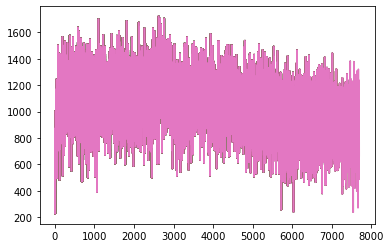

In [11]:
import pylab
tot_rewards, episodes = [], []
state = env.state_init
state_encoded = env.state_encod_arch1(state)
state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
States_track = collections.defaultdict(dict)
track_states_(Episodes)

for episode in range(Episodes):
    # Call all the initialised variables of the environment
    terminal_state = False
    rewards = 0
    reward = 0
    total_days = 1
    prev_day = 0
    curr_day = 0
    env.reset()
    

    #Call the DQN agent
    action_space, state_space, state = env.reset()
    track_state = state
    
    while not terminal_state:
        
        state_encoded = env.state_encod_arch1(state)
        state_encoded = np.reshape(state_encoded, [1, state_size])
        
        # get possible list of actions from the environment
        possible_actions, action_list = env.requests(state)
        
        # pick epsilon-greedy action from possible actions for the current state
        # possible actions is given by the environment
        action = agent.get_action(state_encoded, possible_actions)
        
        # evaluate your reward and next state
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        next_state_encoded = env.state_encod_arch1(next_state)
        next_state_encoded = np.reshape(next_state_encoded, [1, state_size])
        
        # append the experience to the memory
        agent.append_sample(state_encoded, action, reward, next_state_encoded, terminal_state)
        
        # train the model by calling function agent.train_model
        agent.train_model()
        
        # keep track of rewards
        rewards += reward
        prev_day = state[2]
        state = next_state
        curr_day = state[2]
        if prev_day != curr_day:
            total_days = total_days + 1
            
        if total_days > 30:
            terminal_state = True
            
        # once you reach end of 30 days, target model is updated, tot_rewards and episode saved
        if terminal_state == True:
            agent.update_target_model()
            tot_rewards.append(rewards)
            episodes.append(episode)  
    
    
    # this way is much easier to track because other states would be difficult to track as it is heavily dependant on the location and action taken
    track_state_encode = encoded_state(track_state)
    track_state_encoded = env.state_encod_arch1(track_state)
    track_state_encoded = np.reshape(track_state_encoded, [1, state_size])
    track_q_values = agent.get_q_values(track_state_encoded)
    
    for index in range(len(env.action_space)):
        track_action_encode = encoded_action(env.action_space[index])
        tracking_saved(track_state_encode, track_action_encode, track_q_values[index])
        
    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
    
    #save the graph and pickle file)
    if (episode + 1) % 100 == 0:
        print("Episode:", episode + 1, "rewards:", rewards, "epsilon:", agent.epsilon)
        pylab.plot(episodes, tot_rewards)
        # this will create pickle file
        save_obj(agent.get_model_weights(), "pickle_file" + str(rewards))

### Tracking Convergence

In [ ]:
# convergence with tot_reward
plt.plot(episodes, tot_reward)

In [ ]:

# State-action q-value graph
values = States_track['4-0-0']['4-3']
plt.plot(values)

In [ ]:
# State-action q-value graph
values = States_track['4-0-0']['4-2']
plt.plot(values)


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0008*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()